# 绘制内存时间线图，以时间为X轴，内存地址空间为Y轴

In [69]:
import pandas as pd
from sqlalchemy import create_engine

# 使用SQLAlchemy连接
engine = create_engine('sqlite:///data/akita_sim_d14cldqquiqb3d2vnt80.sqlite3')  # 注意路径格式：sqlite:///
df = pd.read_sql_table('trace', engine)
print(df.columns)
print(df.head())

Index(['ID', 'ParentID', 'Kind', 'What', 'Location', 'StartTime', 'EndTime',
       'DeviceID', 'PID', 'Address', 'ByteSize'],
      dtype='object')
                     ID          ParentID     Kind              What  \
0             1_req_out          1@Driver  req_out  *mem.AllocateReq   
1             2_req_out          2@Driver  req_out  *mem.AllocateReq   
2  17367@GPU[1].DRAM[0]     17367_req_out   req_in     *mem.WriteReq   
3         17367_req_out  17358@GPU[1].DMA  req_out     *mem.WriteReq   
4  17368@GPU[1].DRAM[0]     17368_req_out   req_in     *mem.WriteReq   

         Location  StartTime   EndTime  DeviceID  PID     Address  ByteSize  
0          Driver   0.000000  0.000000         1    1  4294971392     16384  
1          Driver   0.000000  0.000000         1    1  4294987776     16384  
2  GPU[1].DRAM[0]   0.000015  0.000015         0    0  4294971392        64  
3      GPU[1].DMA   0.000015  0.000015         0    0  4294971392        64  
4  GPU[1].DRAM[0]   0.000015

In [80]:
import openpyxl

# 向量化计算页范围
df['StartPage'] = df['Address'] // 4096
df['EndPage'] = (df['Address'] + df['ByteSize'] - 1) // 4096

# 筛选出内存相关的请求
mem_df = df[df['What'].isin(['*mem.AllocateReq', '*mem.FreeReq']) 
            | (df['What'].isin(['*mem.ReadReq', '*mem.WriteReq']) & df['Location'].str.contains('DRAM', na=False))
            ]
# print(mem_df.head())
# 保存page_access_df到Excel
mem_df.to_excel('results/page_access.xlsx', 
                         index=False)  # 不保存索引列


# 生成所有页的访问记录
rows = []
for _, row in mem_df.iterrows():
    for page in range(row['StartPage'], row['EndPage'] + 1):
        rows.append({
            'DeviceID': row['DeviceID'],
            # 'PID': row['PID'],
            'PageID': page,
            'AccessType': row['What'],
            'StartTime': row['StartTime'],
            'EndTime': row['EndTime'],
        })

page_access_df = pd.DataFrame(rows)
print(page_access_df)


      DeviceID   PageID        AccessType  StartTime   EndTime
0            1  1048577  *mem.AllocateReq   0.000000  0.000000
1            1  1048578  *mem.AllocateReq   0.000000  0.000000
2            1  1048579  *mem.AllocateReq   0.000000  0.000000
3            1  1048580  *mem.AllocateReq   0.000000  0.000000
4            1  1048581  *mem.AllocateReq   0.000000  0.000000
...        ...      ...               ...        ...       ...
1044         0  1048584      *mem.ReadReq   0.000075  0.000075
1045         0  1048584      *mem.ReadReq   0.000075  0.000075
1046         0  1048584      *mem.ReadReq   0.000075  0.000075
1047         0  1048584      *mem.ReadReq   0.000075  0.000075
1048         0  1048584      *mem.ReadReq   0.000075  0.000075

[1049 rows x 5 columns]


In [81]:
# 按 PageID 分组，计算各页面的关键时间指标
rw_df = page_access_df[page_access_df['AccessType'].isin(['*mem.ReadReq', '*mem.WriteReq'])]
page_rw_stats_df = rw_df.groupby('PageID').agg({
    'StartTime': ['min'],
    "EndTime": ['max'],
    'AccessType': lambda x: list(x.unique())  # 记录所有操作类型
}).reset_index()
page_rw_stats_df.columns = ['PageID', 'FirstAccessTime', 'LastAccessTime', 'AccessTypes']

# 添加生命周期持续时间列
page_rw_stats_df['ActualLifeDuration'] = page_rw_stats_df['LastAccessTime'] - page_rw_stats_df['FirstAccessTime']

print(page_rw_stats_df)

     PageID  FirstAccessTime  LastAccessTime                    AccessTypes  \
0   1048577         0.000015        0.000064  [*mem.WriteReq, *mem.ReadReq]   
1   1048578         0.000015        0.000064  [*mem.WriteReq, *mem.ReadReq]   
2   1048579         0.000015        0.000064  [*mem.WriteReq, *mem.ReadReq]   
3   1048580         0.000015        0.000064  [*mem.WriteReq, *mem.ReadReq]   
4   1048581         0.000066        0.000075  [*mem.WriteReq, *mem.ReadReq]   
5   1048582         0.000066        0.000075  [*mem.WriteReq, *mem.ReadReq]   
6   1048583         0.000066        0.000075  [*mem.WriteReq, *mem.ReadReq]   
7   1048584         0.000066        0.000075  [*mem.WriteReq, *mem.ReadReq]   
8   1048585         0.000031        0.000063  [*mem.WriteReq, *mem.ReadReq]   
9   1048586         0.000046        0.000063  [*mem.WriteReq, *mem.ReadReq]   
10  1048587         0.000061        0.000063  [*mem.WriteReq, *mem.ReadReq]   

    ActualLifeDuration  
0             0.000049  
1

In [82]:
# 筛选分配和释放请求
af_df = page_access_df[page_access_df['AccessType'].isin(['*mem.AllocateReq', '*mem.FreeReq'])]

# 提取分配时间（每个 PageID 的最小 StartTime）
alloc_df = af_df[af_df['AccessType'] == '*mem.AllocateReq'].groupby('PageID')['StartTime'].min().reset_index()
alloc_df.columns = ['PageID', 'AllocateTime']

# 提取释放时间（每个 PageID 的最大 StartTime）
free_df = af_df[af_df['AccessType'] == '*mem.FreeReq'].groupby('PageID')['StartTime'].max().reset_index()
free_df.columns = ['PageID', 'FreeTime']

# 合并分配、释放和读写统计
page_af_stats_df = pd.merge(alloc_df, free_df, on='PageID', how='left')

# 计算最大时间用于未释放页面的填充
max_end_time = df['EndTime'].max()
print(f"Max End Time: {max_end_time}")

# 填充未释放页面的FreeTime
page_af_stats_df['FreeTime'] = page_af_stats_df['FreeTime'].fillna(max_end_time)

# 添加生命周期持续时间列
page_af_stats_df['LifeDuration'] = page_af_stats_df['FreeTime'] - page_af_stats_df['AllocateTime']

print(page_af_stats_df)

Max End Time: 7.5441e-05
     PageID  AllocateTime  FreeTime  LifeDuration
0   1048577      0.000000  0.000075      0.000075
1   1048578      0.000000  0.000075      0.000075
2   1048579      0.000000  0.000075      0.000075
3   1048580      0.000000  0.000075      0.000075
4   1048581      0.000000  0.000075      0.000075
5   1048582      0.000000  0.000075      0.000075
6   1048583      0.000000  0.000075      0.000075
7   1048584      0.000000  0.000075      0.000075
8   1048585      0.000016  0.000075      0.000060
9   1048586      0.000016  0.000075      0.000060
10  1048587      0.000016  0.000075      0.000060


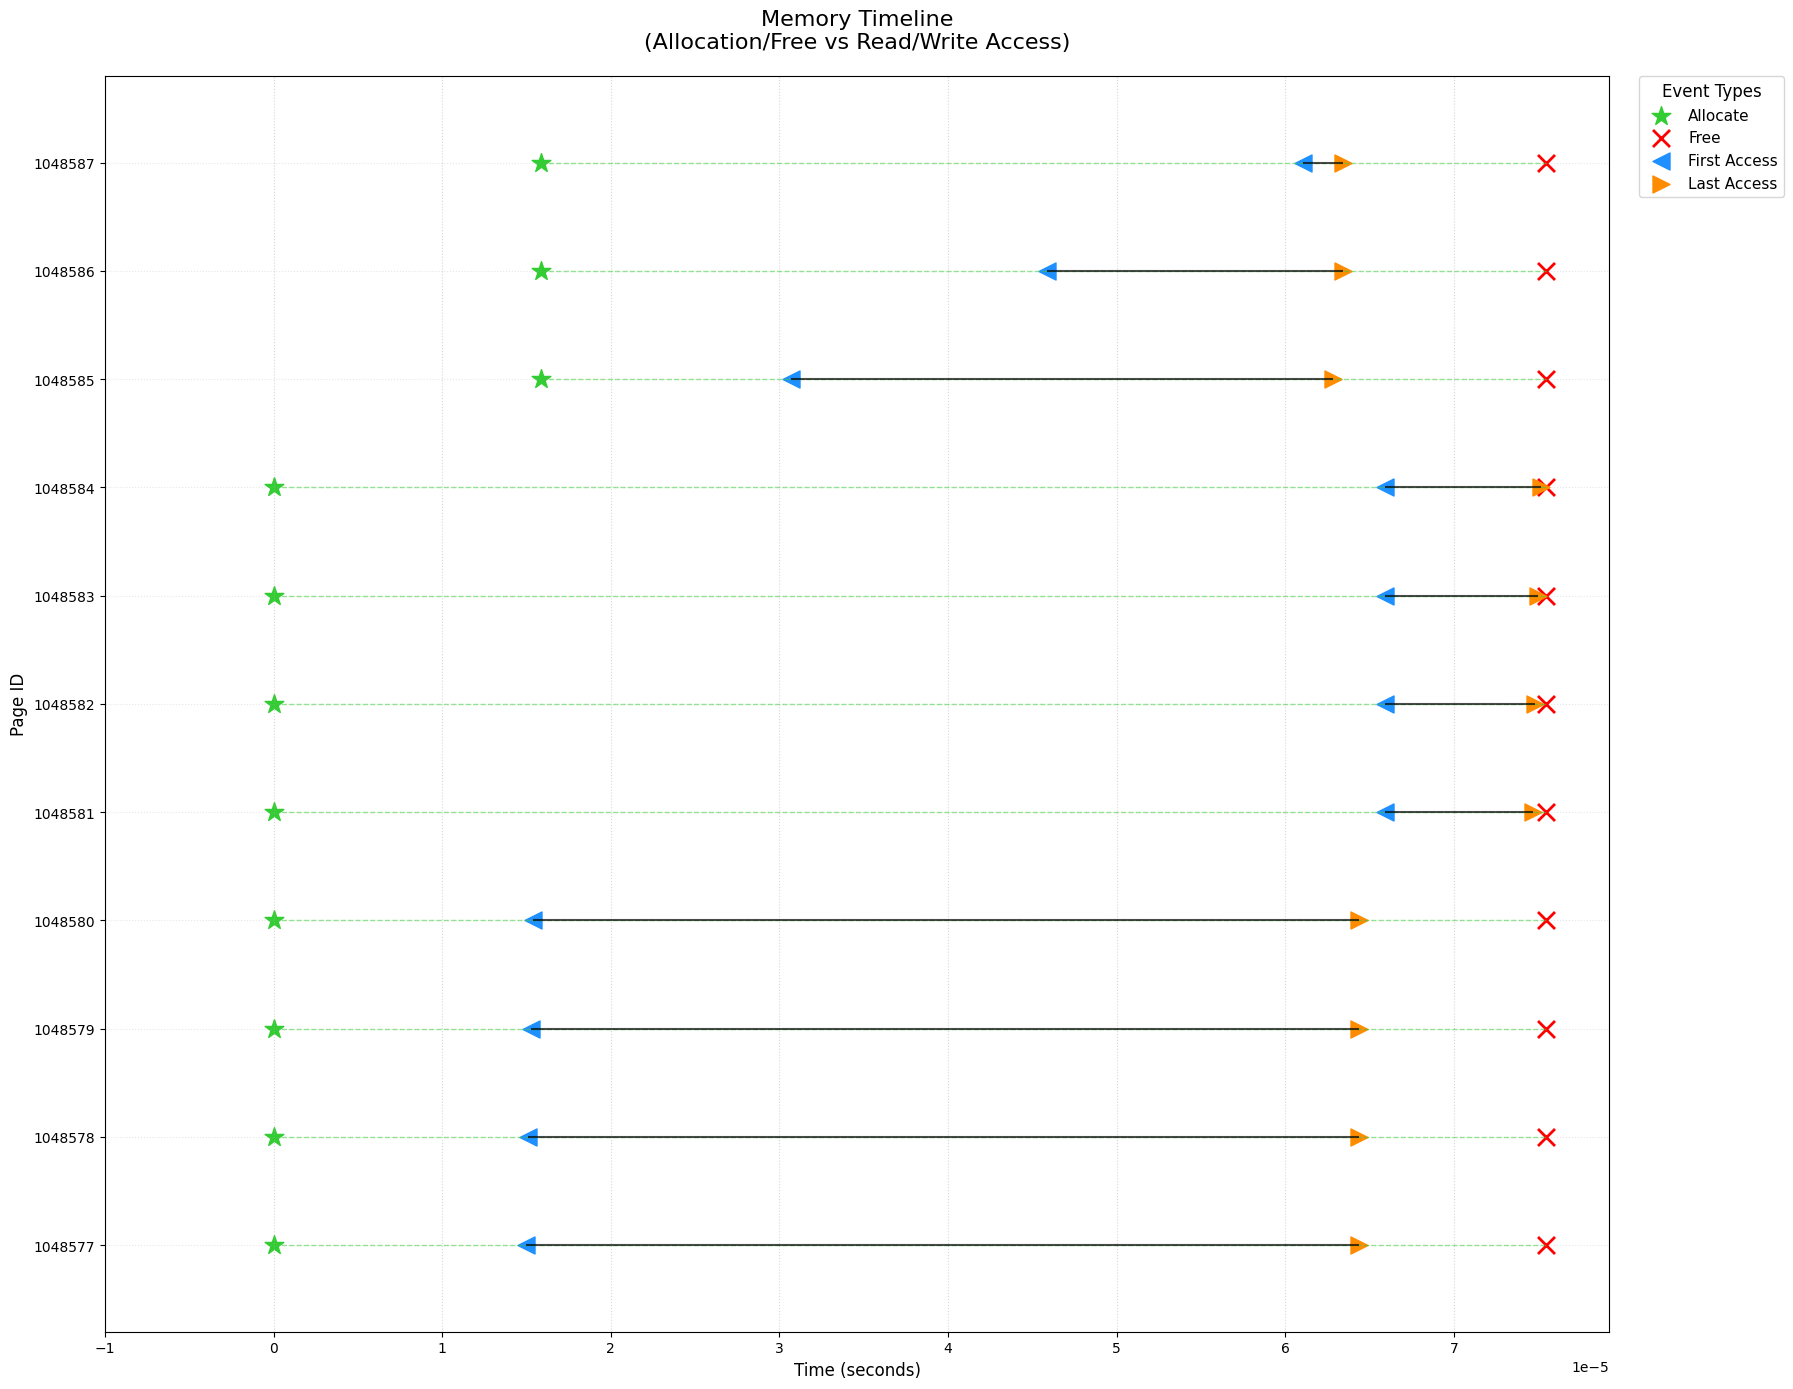

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 14))

# 创建统一的y轴映射
all_pages = sorted(set(page_rw_stats_df['PageID']).union(set(page_af_stats_df['PageID'])))
y_pos_map = {page: i for i, page in enumerate(all_pages)}

# 绘制分配/释放时间线
for _, row in page_af_stats_df.iterrows():
    y_pos = y_pos_map[row['PageID']]
    plt.scatter(row['AllocateTime'], y_pos,
               color='limegreen', marker='*', s=200,
               label='Allocate' if _ == 0 else '')
    plt.scatter(row['FreeTime'], y_pos,
               color='red', marker='x', s=150, linewidth=2,
               label='Free' if _ == 0 else '')
    plt.hlines(y=y_pos,
              xmin=row['AllocateTime'],
              xmax=row['FreeTime'],
              colors='limegreen', linestyles='dashed', alpha=0.5, linewidth=1)

# 绘制读写访问时间线
for _, row in page_rw_stats_df.iterrows():
    y_pos = y_pos_map[row['PageID']]
    plt.scatter(row['FirstAccessTime'], y_pos,
               color='dodgerblue', marker='<', s=150,
               label='First Access' if _ == 0 else '')
    plt.scatter(row['LastAccessTime'], y_pos,
               color='darkorange', marker='>', s=150,
               label='Last Access' if _ == 0 else '')
    plt.hlines(y=y_pos,
              xmin=row['FirstAccessTime'],
              xmax=row['LastAccessTime'],
              colors='black', alpha=0.7, linewidth=1.5)

# 设置坐标轴
plt.yticks(range(len(all_pages)), all_pages, fontsize=10)
plt.xticks(fontsize=10)
plt.xlabel('Time (seconds)', fontsize=12)
plt.ylabel('Page ID', fontsize=12)
plt.title('Memory Timeline\n(Allocation/Free vs Read/Write Access)', fontsize=16, pad=20)

# 调整坐标轴范围
min_time = min(page_af_stats_df['AllocateTime'].min(), page_rw_stats_df['FirstAccessTime'].min())
max_time = max(page_af_stats_df['FreeTime'].max(), page_rw_stats_df['LastAccessTime'].max())
plt.xlim(left=min_time-0.00001, right=max_time*1.05)
plt.ylim(bottom=-0.8, top=len(all_pages)-0.2)

# 添加网格线
plt.grid(True, axis='x', linestyle=':', alpha=0.5)
plt.grid(True, axis='y', linestyle=':', alpha=0.3)

# 将图例移到图表右侧外部
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(),
          bbox_to_anchor=(1.02, 1),  # 将图例放在图表右侧外部
          loc='upper left',          # 锚点在左上角
          borderaxespad=0.,          # 与坐标轴的距离
          frameon=True,              # 显示边框
          fontsize=11,               # 增大字体
          title='Event Types',       # 添加图例标题
          title_fontsize=12)         # 图例标题大小

# 调整布局，为图例留出空间
plt.subplots_adjust(right=0.85)  # 为图例留出15%的右侧空间

plt.tight_layout()
plt.show()

In [92]:
# 合并两个DataFrame
page_stats_df = pd.merge(
    page_rw_stats_df[['PageID', 'FirstAccessTime', 'LastAccessTime', 'ActualLifeDuration']],
    page_af_stats_df[['PageID', 'AllocateTime', 'FreeTime', 'LifeDuration']],
    on='PageID',
    how='outer'  # 保留所有页面，即使只有一种统计
)

# 计算使用率比率
page_stats_df['UsageRatio'] = page_stats_df['ActualLifeDuration'] / page_stats_df['LifeDuration']

# 填充可能存在的NaN值（当LifeDuration为0时）
page_stats_df['UsageRatio'] = page_stats_df['UsageRatio'].fillna(0)

# 计算总持续时间
total_stats = {
    'TotalAllocatedTime': page_stats_df['LifeDuration'].sum(),
    'TotalActiveTime': page_stats_df['ActualLifeDuration'].sum(),
    'OverallUsageRatio': page_stats_df['ActualLifeDuration'].sum() / page_stats_df['LifeDuration'].sum()
}

print("page_stats_df:")
print(page_stats_df)
print(total_stats)

print("\n实际活跃率 = 实际生命周期 / 生命周期 * 100 = ", total_stats['OverallUsageRatio'] * 100, "%")

page_stats_df:
     PageID  FirstAccessTime  LastAccessTime  ActualLifeDuration  \
0   1048577         0.000015        0.000064            0.000049   
1   1048578         0.000015        0.000064            0.000049   
2   1048579         0.000015        0.000064            0.000049   
3   1048580         0.000015        0.000064            0.000049   
4   1048581         0.000066        0.000075            0.000009   
5   1048582         0.000066        0.000075            0.000009   
6   1048583         0.000066        0.000075            0.000009   
7   1048584         0.000066        0.000075            0.000009   
8   1048585         0.000031        0.000063            0.000032   
9   1048586         0.000046        0.000063            0.000018   
10  1048587         0.000061        0.000063            0.000002   

    AllocateTime  FreeTime  LifeDuration  UsageRatio  
0       0.000000  0.000075      0.000075    0.655532  
1       0.000000  0.000075      0.000075    0.653372  
2  